In [1]:
from __future__ import division


import sys
sys.path.append('/home/dimitrios/faculty_hiring')
sys.path.append('/home/dimitrios/')
sys.path.append('/usr/local/lib/python2.7/dist-packages')
sys.path.append('/home/dimitrios/.local/lib/python2.7/')
sys.path.append('/home/dimitrios/.local/lib/python2.7/site-packages')

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics
from collections import Counter

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os

%matplotlib inline

# File locations
faculty_file = '/home/dimitrios/faculty_cs_CURRENT.txt'
inst_file = '/home/dimitrios/inst_cs_CURRENT.txt'
figures_dir = '/home/dimitrios/faculty_hiring/figures/'

# (Optional, these are for loading publication profiles)
dblp_dir = '/home/dimitrios/profiles_DBLP_Nov16/'

/usr/local/lib/python2.7/dist-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [3]:
deep_learning_keywords = ["ANN", "convolutional", "CNN", "recurrent", "RNN", "perceptron", "deep learning", 
                          "deep-learning", "recursive neural net", "stochastic gradient descent", "SGD", "LSTM",
                          "long short-term memory", "GAN", "generative adversarial network", "theano", "tensorflow",
                          "siamese network", "alexnet", "neural network", "keras", "deep belief net", 
                          "deep reinforcement learning", "deep neural network", "DNN", "boltzmann machine", 
                          "recursive auto-encoding", "recursive autoencoding", "hidden layer", "convnet", 
                          "rectified linear unit", "relu", "pooling", "gated recurrent unit", "gru", 
                          "multilayer perceptron", "mlp", "autoencoder", "auto-encoder", "activation function", 
                          "affine layer", "backprop", "back-prop", "back prop", "bptt", "feedforward", 
                          "feed-forward", "actor-critic", "deepmind", "ladder network", "zf net", "dense layer", 
                          "adadelta", "adagrad", "average-pooling", "bidirectional rnn", "bidirectional recurrent", 
                          "categorical cross-entropy loss", "dbn", "deep dream", "googlenet", "highway layer", 
                          "imagenet", "ilsvrc", "inception module", "max-pooling", "noise-contrastive estimation", 
                          "noise contrastive estimation", "restricted boltzmann", "rbn", "recursive neural network", 
                          "resnet", "rmsprop", "vanishing gradient", "vgg", "convnet", "artificial neural network"]

**Note:** How will these results differ based on domain? Any other domains to consider?

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [4]:
def faculty_at_institution(institution_name):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## General trend in deep-learning research

In [5]:
def distribution(asst_faculty, keywords):
    yearly_rate = Counter()
    for f in asst_faculty:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in keywords):
                    yearly_rate[pub['year']] += 1
                
    return yearly_rate 

dist = distribution(asst_faculty, deep_learning_keywords)

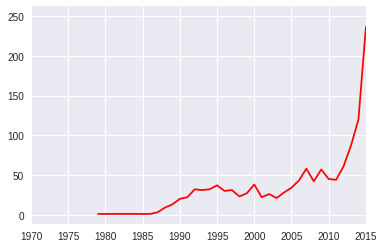

In [6]:
x = dict(dist).keys(); y = [];
for year, count in dict(dist).items():
    y.append(count)
    
plt.plot(x, y, color = 'r')
plt.xlim(1970, 2015)
plt.show()

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [7]:
place = 'University of Montreal'

In [8]:
def get_hires_and_publications(place, keywords):
    hires_and_publications = []
    for f in faculty_at_institution(place):
        person = {"facultyName": f.facultyName}
    
        person["start"] = 2020; person["end"] = 0;
        for job in f.faculty:
            if job['place'] == place and not (job['start_year'] is None):
                person["start"] = min(job['start_year'], person["start"])
                person["end"] = max(job['end_year'], person["end"])
    
        if person["end"] == 0:
            person["end"] = 2011
        if person["start"] == 2020:
            continue
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                relevant_venue = False
                if pub.has_key('venue') and not (pub['venue'] is None):
                    if any((pub['venue'].lower().count(keyword) > 0) for keyword in keywords):
                        relevant_venue = True
                
                if any((pub['title'].lower().count(keyword) > 0) for keyword in keywords) or relevant_venue:
                    relevant_pubs.append(pub['year'])
                        
        person["pubs"] = relevant_pubs
    
        hires_and_publications.append(person)
    
    return hires_and_publications

In [9]:
#get_hires_and_publications(place, deep_learning_keywords)

Let's plot the above data so we can better see when hires and publications occurred.

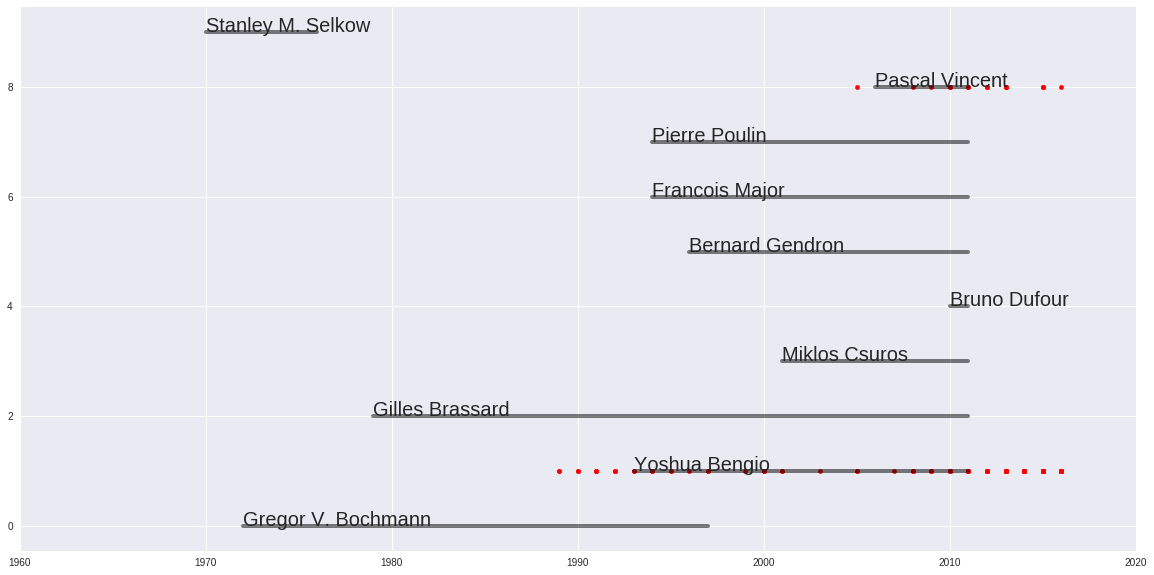

In [10]:
def plot_careers(place, keywords):
    i = 0
    plt.figure(figsize=(20,10))
    for person in get_hires_and_publications(place, keywords):
        #print person['facultyName']
        plt.plot([person["start"], person["end"]], [i, i], linewidth= 4, color = 'k', alpha = .5)
        plt.text(person["start"], i, person["facultyName"], fontsize=20)
    
        if len(person['pubs']) > 0:
            plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 20, color = 'r')
        i += 1

    plt.xlim(1960, 2020)
    plt.show()

plot_careers(place, deep_learning_keywords)

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

**Note:** Should we consider:
(1) window around hire data - the person the made the first deep learning contribution
(2) window around first relevant pub data

Keep in mind: do we often see a big gap in deep learning pubs between pre- and post-hire?

Did the university hire someone who works on deep-learning within that date - 2 years (allowing for some start-up time)?

In [26]:
delta_t = 2;
def find_infected_hire(delta_t, place, keywords):
    '''
    Returns None if no infected hire found, otherwise the first hire
    is returned as (person, year of infectious publication).
    '''
    candidates = []
    for person in get_hires_and_publications(place, keywords):
        sorted_pubs = sorted(person["pubs"])
        if not person["start"] or len(sorted_pubs) == 0:
            continue
        deltas = map(lambda x: x - person["start"], sorted_pubs)
        try:
            pub_ix = next((i for i, v in enumerate(deltas) if abs(v) <= delta_t
                         and any(person["start"] <= pub <= person["end"] for pub in person["pubs"])))
        except:
            pub_ix = None
        if pub_ix is not None:
            candidates.append((person, sorted_pubs[pub_ix]))

    if not candidates:
        return None
    else:
        return min(candidates, key=lambda x: x[1])
        
print "\nWas a \"deep-learning\" researcher hired who might have led to the research area? {0}".format(find_infected_hire(delta_t, place, deep_learning_keywords))


Was a "deep-learning" researcher hired who might have led to the research area? ({'pubs': [2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2009, 2009, 2009, 2008, 2008, 2008, 2008, 2007, 2005, 2005, 2003, 2001, 2001, 2000, 2000, 2000, 1999, 1997, 1997, 1996, 1995, 1995, 1994, 1994, 1993, 1993, 1992, 1992, 1992, 1991, 1991, 1991, 1990, 1990, 1989, 1989], 'start': 1993, 'fac

## For all universities

In [12]:
def percent_has_relevant_prior_pubs(delta_t, keywords):
    n_no_priors = 0
    n_yes_priors = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hire = find_infected_hire(delta_t, place, keywords)
        if not infected_hire:
            continue
        
        # Were they publishing on deep-learning before their hire date?
        if all(year > infected_hire[0]["start"] for year in infected_hire[0]["pubs"]):
            n_no_priors += 1
        else:
            n_yes_priors += 1
        total += 1
    
    print("Hires with no background in topic: {0}, Hires with background in topic: {1}, Total infected univesities: {2}".format(n_no_priors, n_yes_priors, total))
    return (float(n_no_priors)/total, float(n_yes_priors)/total)

(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, deep_learning_keywords)

Hires with no background in topic: 24, Hires with background in topic: 54, Total infected univesities: 78


In [13]:
(prob_no_priors, prob_yes_priors)

(0.3076923076923077, 0.6923076923076923)

## For different topics

In [14]:
topic_modeling_keywords = ["probabilistic latent semantic analysis", "PLSA", "latent dirichlet allocation", "LDA",
                           "latent semantic analysis", "lsa", "latent semantic indexing", "lsi", "topic model"]

In [15]:
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, topic_modeling_keywords)

Hires with no background in topic: 26, Hires with background in topic: 61, Total infected univesities: 87


In [16]:
(prob_no_priors, prob_yes_priors)

(0.2988505747126437, 0.7011494252873564)

In [17]:
incremental_keywords = ["incremental computation",
"self-adjusting computation",
"program derivative",
"dbtoaster",
"incremental view",
"dependency graph",
"partial evaluation",
"incremental computing",
"incrementally compute",
"frtime",
"adaptive functional programming",
"delta ml",
"haskell adaptive",
"cornell synthesizer generator",
"icedust",
"adapton",
"one-way dataflow constraints",
"reactive computation",
"differential dataflow",
"jane street incremental",
"incremental datalog",
"incremental prolog",
"incremental type checking",
                       "self-adjusting",
                       "memo table",
                       "memoization",
                       "interaction",
                       "cache",
                       "caching",
                       "observer pattern"]

In [18]:
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords)

Hires with no background in topic: 44, Hires with background in topic: 101, Total infected univesities: 145


In [19]:
(prob_no_priors, prob_yes_priors)

(0.30344827586206896, 0.696551724137931)

In [ ]:
session_type_keywords = ["session type"]

In [ ]:
percent_has_relevant_prior_pubs(2, session_type_keywords)

In [ ]:
contracts_keywords = ["contract"]

In [ ]:
percent_has_relevant_prior_pubs(2, contracts_keywords)

In [ ]:
csl_keywords = ["concurrent separation logic"]

In [ ]:
percent_has_relevant_prior_pubs(2, csl_keywords)

In [ ]:
cost_semantics_keywords = ["cost semantics"]

In [ ]:
percent_has_relevant_prior_pubs(2, cost_semantics_keywords)

In [ ]:
probabilistic_keywords = ["probabilistic programming", "probabilistic program"]

In [ ]:
percent_has_relevant_prior_pubs(2, probabilistic_keywords)

In [ ]:
frp_keywords = ["functional reactive", "functionally reactive"]

In [ ]:
percent_has_relevant_prior_pubs(2, frp_keywords)

In [ ]:
refinement_keywords = ["refinement type"]

In [ ]:
percent_has_relevant_prior_pubs(2, refinement_keywords)

In [ ]:
percent_has_relevant_prior_pubs(2, ["enough","high","low","found","large","small","below","above"])

In [27]:
percent_has_relevant_prior_pubs(2, ["reactive"])

Hires with no background in topic: 9, Hires with background in topic: 6, Total infected univesities: 15


(0.6, 0.4)